# ORIE 5355/INFO 5370 HW 1: Survey Weighting

 - Name: Dean Xu
 - Net-id: hx332
 - Date: 2025/9/16
 - Late days used for this assignment: 0
 - Total late days used (counting this assignment): 0
 - People with whom you discussed this assignment: /

After you finish the homework, please complete the following (short, anonymous) post-homework survey: https://forms.gle/CdpUFN582d15kZSH9


We have marked questions in <font color='green'> green </font>. Please put answers in the default color. You'll want to write text answers in "markdown" mode instead of code. In Jupyter notebook, you can go to Cell > Cell Type > Markdown, from the menu. Please carefully read the late days policy and grading procedure [here](https://orie5355.github.io/Fall_2025/assignments/). In that link, we also give some tips on exporting your notebook to PDF, which is required for GradeScope submission. 

A few notes about this homework:
1. This homework is purposefully heavy in using the Pandas package. Being able to explore data is an essential data science skill that you'll use throughout this class and your career -- even if the polling/politics application is not interesting to you. I encourage you to practice Pandas and learn how to use it well. Your code will NOT be graded on efficiency.
2. Some of the questions can be interpreted in multiple ways. That is always true in data science. You'll need to make judgment calls for what analysis to do. For the homework, you'll still receive full points for any "reasonable" choice. Also feel free to ask questions on EdStem. 

Note: We sometimes provide sample images of what your output should look like. These are for clarification of what we are looking for. The numbers in the images are not necessarily correct, and your output does not need to look exactly like the images.

# Conceptual component

### 1) Reading

<font color='green'> Please read Sections 3 and 4 (pages 6-13) here: https://www.nber.org/system/files/working_papers/w20830/w20830.pdf, and answer the following questions.

<font color='green'> Please summarize the sections in no more than two sentences. 

<font color='green'> Do you think it's a problem that most ratings are positive? If so, why? Answer in no more than four sentences. Please incorporate concepts discussed in class in your answer. 

### 2) Personal reflection

<font color='green'> Think back to a time that you trained a model on data from people or gathered opinions via a survey (an informal one is fine). If you have not done that before, you may answer these questions about an article in the news that reported on public opinions or a model that you think might be in deployment at a company or organization with which you interact (for example, Amazon, google maps, etc)

<font color='green'> Briefly summarize the scenario in no more than two sentences. 

<font color='green'> What was the construct that you cared about/wanted to measure? What was the measurement (numerical data)? In what ways did the measurement not match the construct you cared about? Answer in no more than 4 sentences.  

<font color='green'> What selection biases/differential non-response issues occurred and how did it affect your measurement? (If your answer is "None," explain exactly why you believe the assumptions discussed in class were met). Answer in no more than 3 sentences. 

<font color='green'> Given what we have learned in class so far, what would you do differently if faced with the same scenario again? Answer in no more than 3 sentences. 

# Programming component

<font color='green'> In this part of the homework, we provide you with data from a poll in Florida before the 2016 Presidential election in the United States. We also provide you with (one pollster's) estimates of who will vote in the 2016 election, made before the election. You will use this data and apply the weighting techniques covered in class.

## Preliminaries to load packages and data

In [1]:
import pandas as pd
import numpy as np

In [2]:
dfpoll = pd.read_csv('polling_data_hw1.csv') # raw polling data
dfpoll.head()

,candidate,age,gender,party,race,education
0,Someone else,30-44,Male,Independent,White,College
1,Hillary Clinton,45-64,Male,Republican,Hispanic,College
2,Hillary Clinton,30-44,Male,Independent,Hispanic,College
3,Hillary Clinton,65+,Female,Democrat,White,College
4,Donald Trump,65+,Female,Republican,White,High School


In [3]:
dfdemographic = pd.read_csv('florida_proportions_hw1.csv') # proportions of population
dfdemographic.head()

,Electoral_Proportion,Demographic_Type_1,Demographic_Type_2,Demographic_1,Demographic_2
0,0.388,party,NaN,Democrat,NaN
1,0.399,party,NaN,Republican,NaN
2,0.213,party,NaN,Independent,NaN
3,0.446,gender,NaN,Male,NaN
4,0.554,gender,NaN,Female,NaN


In [4]:
dfdemographic.tail()

,Electoral_Proportion,Demographic_Type_1,Demographic_Type_2,Demographic_1,Demographic_2
112,0.034,race,education,Hispanic,Some College
113,0.028,race,education,Hispanic,College
114,0.011,race,education,Other,High School
115,0.011,race,education,Other,Some College
116,0.015,race,education,Other,College


`dfdemographic` contains estimates of likely voters in Florida in 2016. When `Demographic_Type_2` is `NaN`, the row refers to just the marginal population percentage of the group in `Demographic_1` of type `Demographic_Type_1`. When it is not `NaN`, the row has the joint distribution of the corresponding demographic groups.

For example, row 0 means that 38.8% of the electorate is from the Democrat party. Row 113 means that 2.8% of the electorate is Hispanic AND graduated college. 

## Part A: Raw visualization

<font color='green'> Here, we'll visualize whether the respondents in the poll match the likely voter estimates. Create a scatter-plot where each point represents one Demographic group (for example, people who identify as Independet: party-Independent), where the X axis is the `Electoral_Proportion` in `dfdemographic`, and the Y axis is the proportion in `dfpoll` (Hint: you will need to calculate this yourself). 

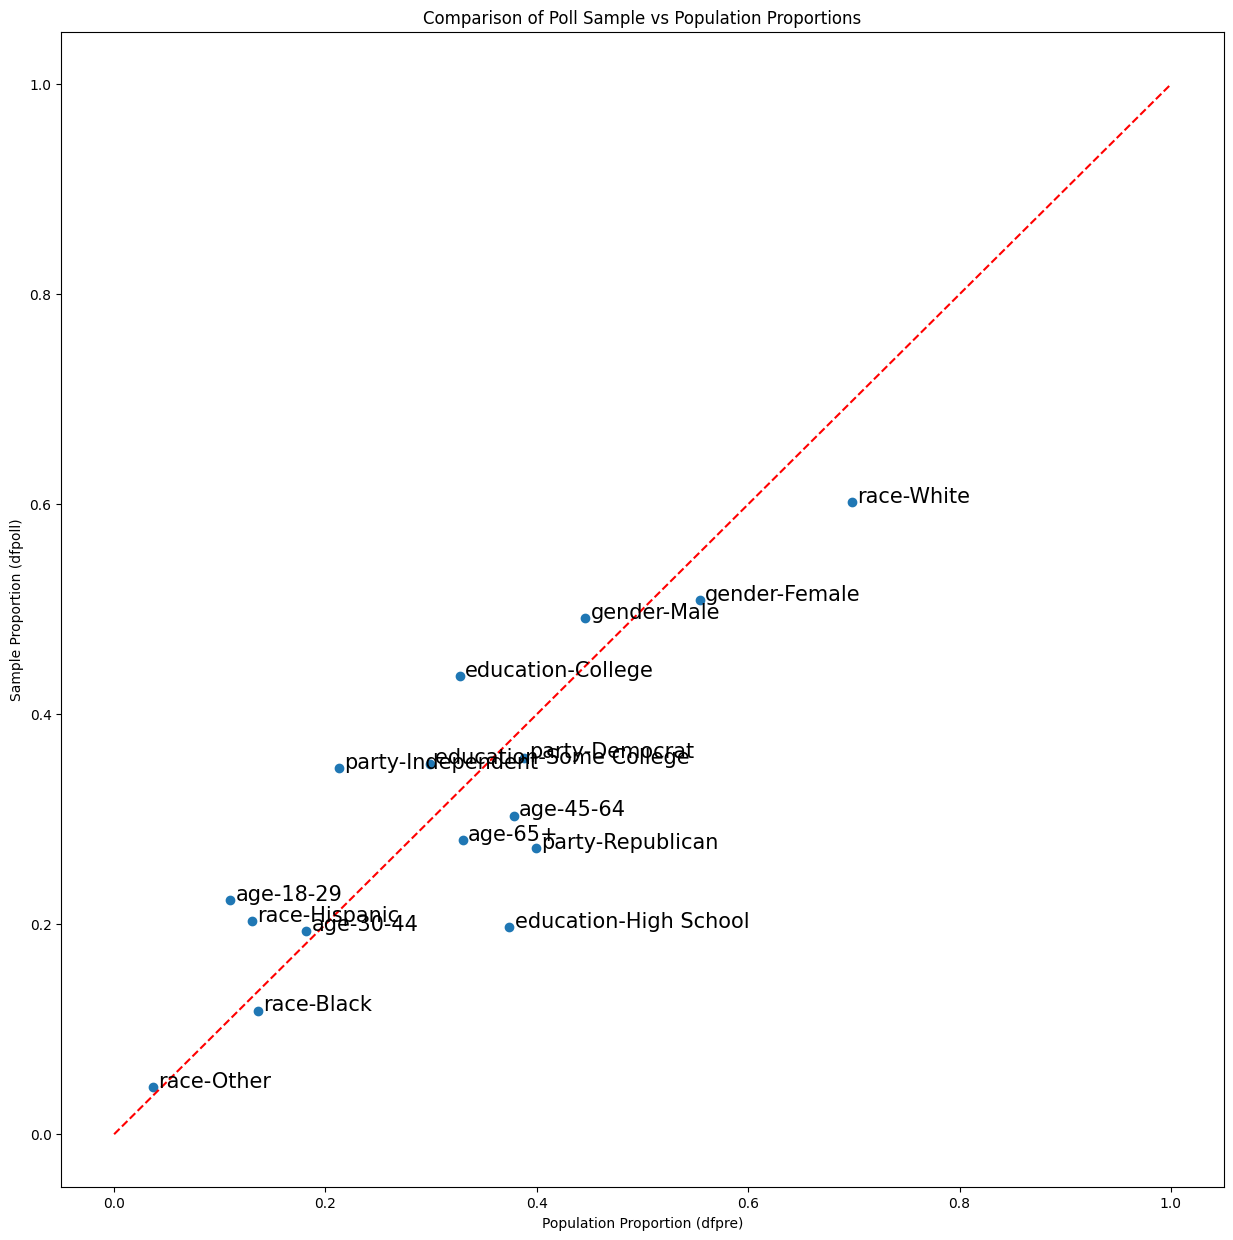

,Group,Electoral_Proportion,Sample_Proportion
0,party-Democrat,0.388,0.358708
1,party-Republican,0.399,0.272203
2,party-Independent,0.213,0.348328
3,gender-Male,0.446,0.491349
4,gender-Female,0.554,0.508651
5,age-18-29,0.110,0.222607
6,age-30-44,0.182,0.193772
7,age-45-64,0.378,0.303345
8,age-65+,0.330,0.280277
9,race-White,0.698,0.602076


In [8]:
import matplotlib.pyplot as plt

dfpre_marginal = dfdemographic[dfdemographic['Demographic_Type_2'].isna()]


sample_props = {}

for demo_type in dfpre_marginal['Demographic_Type_1'].unique():
    
    counts = dfpoll[demo_type].value_counts(normalize=True)
    
    temp = counts.reset_index()
    temp.columns = ['Demographic_1', 'Sample_Proportion']
    temp['Demographic_Type_1'] = demo_type
    sample_props[demo_type] = temp


df_sample_props = pd.concat(sample_props.values(), ignore_index=True)


df_compare = dfpre_marginal.merge(
    df_sample_props,
    on=['Demographic_Type_1', 'Demographic_1'],
    how='left'
)


df_compare['Group'] = df_compare['Demographic_Type_1'] + '-' + df_compare['Demographic_1']

plt.figure(figsize=(15,15))
plt.scatter(df_compare['Electoral_Proportion'], df_compare['Sample_Proportion'], alpha=1)

plt.plot([0,1],[0,1], color='red', linestyle='--')

for i, row in df_compare.iterrows():
    plt.text(row['Electoral_Proportion']+0.005, row['Sample_Proportion'], row['Group'], fontsize=15)

plt.title('Comparison of Poll Sample vs Population Proportions')
plt.xlabel('Population Proportion (dfpre)')
plt.ylabel('Sample Proportion (dfpoll)')

plt.show()

df_compare[['Group','Electoral_Proportion','Sample_Proportion']]


<font color='green'> `dfdemographic` tells us the true proportion of each demographic group in the entire population, the calculated proportion from dfpoll tells us the proportion of each demographic group represented in the poll. For a poll to be representative of the population, ideally we would want the latter to be the same as the former. However, this is hard to achieve in practice.


In your view, which group is most over-represented? Most under-represented? Why? Answer in no more than 3 sentences. There are multiple reasonable definitions of "over" or "under" represented; any choice is fine as long as you justify your answer.</font>

## Part B: Weighting

<font color='green'> For this question, we'll ignore people who answered anything but "Hillary Clinton" or "Donald Trump."


You'll notice that some of the groups in the polling data ("refused") do not show up in the population percentages. For the questions that require weighting by demographics, ignore those respondents.



### 1) Raw average

<font color='green'> Below, report the "raw polling average," the percentage of people "Hillary Clinton" divided by the number who answered either Hillary or Trump.

In [11]:
df = dfpoll[dfpoll['candidate'].isin(["Hillary Clinton", "Donald Trump"])]

raw_avg = (df["candidate"] == "Donald Trump").mean()

print("Raw average - Clinton support:", 1 - raw_avg)
print("Raw average - Trump support:", raw_avg)

Raw average - Clinton support: 0.5458333333333334
Raw average - Trump support: 0.45416666666666666


### 2) Single dimensional marginal weighting (on just 1 demographic type)

<font color='green'> For each demographic type separately -- age, gender, party, race, and education -- weight the poll by just that demographic type, in accordance to the population proportions given. Report the resulting poll results, and briefly (at most 3 sentences) describe what you observe.


For example, when weighted by race, you'll report:

Weighted by race --- Clinton: 0.531, Trump: 0.469

(your results might be different due to rounding/precision, but we do not expect the difference to be large)


In [12]:
import pandas as pd

def weighted_poll_by_demo(df, dfdemographic, demo_type):
    """
    Weighted by a single demographic characteristic (demo_type).
    """ 
    # === Step 1: Population Proportion ===
    pop_demo = dfdemographic[
        (dfdemographic["Demographic_Type_1"] == demo_type) &
        (dfdemographic["Demographic_Type_2"].isna())
    ][["Demographic_1", "Electoral_Proportion"]]
    
    pop_dict = pop_demo.set_index("Demographic_1")["Electoral_Proportion"].to_dict()
    
    # === Step 2: Sample Proportion ===
    sample_dict = df[demo_type].value_counts(normalize=True).to_dict()
    
    # === Step 3: Caculate Weights ===
    weights = {k: pop_dict[k] / sample_dict[k] 
               for k in pop_dict.keys() if k in sample_dict}
    
    # === Step 4: Assign weight ===
    df["weight"] = df[demo_type].map(weights)
    
    # === Step 5: Caculate weighted support rates ===
    df["is_clinton"] = (df["candidate"] == "Hillary Clinton").astype(int)
    
    p_clinton = (df["is_clinton"] * df["weight"]).sum() / df["weight"].sum()
    p_trump = 1 - p_clinton
    
    return p_clinton, p_trump


# Caculate weighted support rates for all marginal dimensions
for demo in ["age", "gender", "party", "race", "education"]:
    p_clinton, p_trump = weighted_poll_by_demo(df.copy(), dfdemographic, demo)
    print(f"Weighted by {demo} --- Clinton={p_clinton:.3f}, Trump={p_trump:.3f}")


Weighted by age --- Clinton=0.531, Trump=0.469
Weighted by gender --- Clinton=0.550, Trump=0.450
Weighted by party --- Clinton=0.499, Trump=0.501
Weighted by race --- Clinton=0.531, Trump=0.469
Weighted by education --- Clinton=0.544, Trump=0.456


The results show that weighting different demographic characteristics significantly alters the estimates. When weighted by party affiliation, Clinton and Trump's support is almost identical (0.499 vs. 0.501), while when weighted by gender or education, Clinton's support rate is slightly higher. Overall, this suggests that the sample differs most from the population in partisan composition, while biases in gender and education also have a certain impact on the results.

### 2-dimensional joint distribution weighting

<font color='green'>Now, for each pair of demographic types in dfdemographic, do the same -- weight the poll by that pair of demographic types, in accordance to the given joint distributions, and briefly (at most 3 sentences) describe what you observe.

For example, when weighted by race and age, you'll find:

Weighted by age and race: Clinton: 0.523, Trump: 0.477

In [13]:
def weighted_poll_by_joint(df, dfdemographic, demo1, demo2):
    """
    Weighted calculation based on two demographic characteristics (demo1, demo2).
    """
    # === Step 1: Extract Population Proportion ===
    pop_joint = dfdemographic[
        (dfdemographic["Demographic_Type_1"] == demo1) &
        (dfdemographic["Demographic_Type_2"] == demo2)
    ][["Demographic_1", "Demographic_2", "Electoral_Proportion"]]
    
    if pop_joint.empty:
        raise ValueError(f"⚠️ The joint distribution of ({demo1}, {demo2}) was not found in the population data. Consider using marginal approximations.")
    
    pop_dict = {(row["Demographic_1"], row["Demographic_2"]): row["Electoral_Proportion"]
                for _, row in pop_joint.iterrows()}
    
    # === Step 2: Sample proportion ===
    sample_counts = df.groupby([demo1, demo2]).size()
    sample_props = (sample_counts / sample_counts.sum()).to_dict()
    
    # === Step 3: Calculating weights ===
    weights = {}
    for k, pop_val in pop_dict.items():
        if k in sample_props and sample_props[k] > 0:
            weights[k] = pop_val / sample_props[k]
        else:
            # This combination does not appear in the sample, skip
            continue
    
    if not weights:
        raise ValueError(f"⚠️ No available sample population combination ({demo1}, {demo2}) was found. Please check the data.")
    
    # === Step 4: Assign weight ===
    df = df.copy()
    df["joint_key"] = list(zip(df[demo1], df[demo2]))
    df["weight"] = df["joint_key"].map(weights)
    
    # Remove rows where weight is NaN (i.e. combinations that exist in the population but not in the sample)
    df = df.dropna(subset=["weight"])
    
    # === Step 5: Calculating weighted support ===
    df["is_clinton"] = (df["candidate"] == "Hillary Clinton").astype(int)
    p_clinton = (df["is_clinton"] * df["weight"]).sum() / df["weight"].sum()
    p_trump = 1 - p_clinton
    
    return p_clinton, p_trump
    
# Get all (demo1, demo2) combinations that exist in the overall data
pairs = dfdemographic[~dfdemographic["Demographic_Type_2"].isna()][
    ["Demographic_Type_1", "Demographic_Type_2"]
].drop_duplicates()

# Run weighted calculations for each combination
results = []
for _, row in pairs.iterrows():
    demo1, demo2 = row["Demographic_Type_1"], row["Demographic_Type_2"]
    try:
        p_clinton, p_trump = weighted_poll_by_joint(df.copy(), dfdemographic, demo1, demo2)
        results.append((demo1, demo2, p_clinton, p_trump))
    except ValueError as e:
        results.append((demo1, demo2, None, None))
        print(f"⚠️ Pass ({demo1}, {demo2}): {e}")

# Print results
for demo1, demo2, pc, pt in results:
    if pc is not None:
        print(f"Weighted by ({demo1}, {demo2}) --- Clinton={pc:.3f}, Trump={pt:.3f}")
    else:
        print(f"Weighted by ({demo1}, {demo2}) --- Unable to calculate (population data missing or insufficient sample)")

Weighted by (party, gender) --- Clinton=0.503, Trump=0.497
Weighted by (party, age) --- Clinton=0.499, Trump=0.501
Weighted by (party, race) --- Clinton=0.502, Trump=0.498
Weighted by (party, education) --- Clinton=0.494, Trump=0.506
Weighted by (gender, age) --- Clinton=0.533, Trump=0.467
Weighted by (gender, race) --- Clinton=0.534, Trump=0.466
Weighted by (gender, education) --- Clinton=0.548, Trump=0.452
Weighted by (age, race) --- Clinton=0.524, Trump=0.476
Weighted by (age, education) --- Clinton=0.526, Trump=0.474
Weighted by (race, education) --- Clinton=0.515, Trump=0.485


### 3) 2-dimensional marginal 

<font color='green'>We don't always have access to joint distributions across the population -- for example, it may be hard to estimate from past exit polls (surveys done as people are leaving the polling station) what the joint distribution of education and gender is, for example. However, access to marginal distributions are often available. 

As discussed in class, one strategy when you don't have access to joint distributions -- only marginals -- is to _multiply_ the marginal distributions. For example, if 50% of your population is Democratic and 50% is a woman, then pretend that 50% times 50% = 25% of your population is a Democratic women. Clearly this technique is not perfect, but it is sometimes a useful heuristic. (Hint: you can use the marginal distribution provided in dfdemographic)

For the following pairs of Demographic types, report the weighting results if you use the joint distributions in dfdemographic versus if you approximate the joint distribution using the marginals. Briefly (at most 3 sentences) describe what you observe.

(party, gender)

(race, gender)

As an example output, here's the results for two other pairs of demographics (your results might be different due to rounding, but we do not expect the difference to be large):

| Demo1   | Demo2     |    Joint |   Marginal |
|:--------|:----------|---------:|-----------:|
| age     | race      | 0.523431 |   0.525669 | 
| age     | education | 0.525068 |   0.523938 |  

In [16]:
def weighted_poll_by_marginal_approx(df, dfdemographic, demo1, demo2):
    """
    Compare true joint distribution vs marginal approximation
    for two demographic variables (demo1, demo2).

    Returns:
        joint_clinton, joint_trump, marginal_clinton, marginal_trump
    """
    # === Part 1: True joint distribution (if available) ===
    try:
        joint_clinton, joint_trump = weighted_poll_by_joint(df.copy(), dfdemographic, demo1, demo2)
    except ValueError:
        joint_clinton, joint_trump = np.nan, np.nan

    # === Part 2: Marginal approximation ===
    # Population proportions for demo1
    pop1 = dfdemographic[
        (dfdemographic["Demographic_Type_1"] == demo1) &
        (dfdemographic["Demographic_Type_2"].isna())
    ][["Demographic_1", "Electoral_Proportion"]].set_index("Demographic_1")["Electoral_Proportion"].to_dict()

    # Population proportions for demo2
    pop2 = dfdemographic[
        (dfdemographic["Demographic_Type_1"] == demo2) &
        (dfdemographic["Demographic_Type_2"].isna())
    ][["Demographic_1", "Electoral_Proportion"]].set_index("Demographic_1")["Electoral_Proportion"].to_dict()

    # Normalize keys to avoid (A,B) vs (B,A) mismatch
    def normalize_key(k):
        return tuple(sorted(k))

    # Construct marginal approximation by independence assumption
    pop_marginal = {normalize_key((k1, k2)): v1 * v2 
                    for k1, v1 in pop1.items() 
                    for k2, v2 in pop2.items()}

    # Sample proportions
    sample_counts = df.groupby([demo1, demo2]).size()
    sample_props = (sample_counts / sample_counts.sum()).to_dict()
    sample_props = {normalize_key(k): v for k, v in sample_props.items()}

    # Compute weights
    weights = {k: pop_marginal[k] / v for k, v in sample_props.items()
               if v > 0 and k in pop_marginal}

    # Assign weights to respondents
    df = df.copy()
    df["joint_key"] = list(zip(df[demo1], df[demo2]))
    df["joint_key"] = df["joint_key"].map(normalize_key)
    df["weight"] = df["joint_key"].map(weights)
    df = df.dropna(subset=["weight"])

    # Compute weighted Clinton support
    df["is_clinton"] = (df["candidate"] == "Hillary Clinton").astype(int)
    marginal_clinton = (df["is_clinton"] * df["weight"]).sum() / df["weight"].sum()
    marginal_trump = 1 - marginal_clinton

    return joint_clinton, joint_trump, marginal_clinton, marginal_trump


pairs = [("party", "gender"), ("race", "gender")]

for demo1, demo2 in pairs:
    jc, jt, mc, mt = weighted_poll_by_marginal_approx(df.copy(), dfdemographic, demo1, demo2)
    print(f"({demo1}, {demo2}) - Joint: Clinton={jc:.3f}, Trump={jt:.3f}")
    print(f"({demo1}, {demo2}) - Marginal: Clinton={mc:.3f}, Trump={mt:.3f}")

(party, gender) - Joint: Clinton=0.503, Trump=0.497
(party, gender) - Marginal: Clinton=0.504, Trump=0.496
(race, gender) - Joint: Clinton=nan, Trump=nan
(race, gender) - Marginal: Clinton=0.535, Trump=0.465


For (party, gender), the results from the joint distribution and the marginal approximation are almost identical, suggesting that assuming independence works well in this case. For (race, gender), the joint distribution is unavailable, and the marginal approximation slightly increases Clinton’s share relative to Trump. This indicates that while marginal approximations can be reasonable substitutes, they may introduce bias when true joint distributions are missing.

### 4) Bonus points (up to 2 points): Implement a "cheap" version of the MRP technique mentioned in class.

<font color='green'> The above techniques use the mean answer among people who share a demographic as the estimate for that demographic. But that wastes information _across_ demographics. For example, maybe people who only have "Some College" are similar enough to people who have "High School" as to provide some useful information. 

First, do the following: use a logistic regression (or your favorite prediction tool) to predict candidate choice, using the demographics. You might want to convert some demographics (like education) to ordered numeric (e.g., 1, 2, 3) as opposed to using discrete categories. 

Here, you will earn partial bonus points by just reporting the predictions and comparing them to the means of each covariate group in the raw polling data. Give a scatter-plot, where each point is one combination of full demographics (age, gender, party, race/ethnicity, education), the X axis is the raw polling average for that combination, and the Y axis is your regression prediction for that combination.   

Then, once you have predictions for each set of covariates, "post-stratify" to get a single population estimate by plugging them into the above weighting techniques, where you use the predictions instead of the raw averages in that cell. Report the resulting estimates if you do the 2-dimensional joint weighting (on every pair).

### 5) Bonus points (up to 2 points): Implement full "raking" using all the demographic covariates, i.e., match all the marginals without assuming independence, as opposed to just one or two marginal distributions.

<font color='green'> Hint: at the heart of raking is calculating a weight for each survey respondent, so that the weights, when summed up, matches the population on desired marginals as much as possible. 

For example, suppose we have a survey with two respondents, A likes chocolate and B hates chocolate. We know that in the population, 80\% of people like chocolate (the number is made up). So in a representative sample with 2 respondents, we would expect to see 1.6 respondents who like chocolate. Thus, one possible thing to do is we assign A with weight 1.6 and B with weight 0.4, and then use these weights to weigh their answers to the question we care about.

Of course, when the number of respondents and the number of demographic dimensions that we want to match get larger, finding the weights itself becomes harder. There are mainly two ways to do this. The first is through an iterative approach known as Iterative Proportional Fitting (IPF). IPF iterates through each demographic variable at a time, and adjusts the weights of all respondents through post stratification. IPF is easier to implement by hand by just following the instructions. The second approach is known as generalized raking, which is done through solving an optimization problem, and proposed by [Deville, J. C., Särndal, C. E., & Sautory, O. (1993)](https://www.tandfonline.com/doi/abs/10.1080/01621459.1993.10476369). This approach attempts to solve one undesirable outcome of IPF that the resulting weights may be unbalanced, which leads to higher variance in the final estimate. [This blog post](https://dev.to/potloc/generalized-raking-for-survey-weighting-2d1d) gives a nice introduction to generalized raking, while providing a code snippet for implementing it in Python (you will have to make suitable changes, of course.)

## Part C: Uncertainty analysis, choices, and discussion

### 1) Education weighting analysis and "refused" answers

<font color='green'> i. In Part B, you should notice a discrepancy from what we said in class and the data -- weighting by education does _not_ seem to help much in reducing the polling average from being pro-Clinton.

Here, we'll try to dig into the data to see why the methods we tried above might not be perfect, and what data you would want (such as demographic joint distribution) to do better. 

First, aggregate (using the groupby function) the poll results by education. Second, aggregate by education and some of the other covariates (for example, education and race, or education and party). Discuss in 4 sentences or less.

<font color='green'> ii. You'll notice that there are some responses with "refused," and that those people in particular are Trump-leaning. Furthermore, there are likely many people who refused to answer the poll at all, who do not show up in the data. The weighting techniques we used above would ignore these people. How would you adjust your procedures/estimates above to take them into account? Answer in at most 3 sentences.

<font color='green'> None of the above techniques deal with selection biases/non-response on _un-measured_ covariates. Do you think that may be an important concern in this dataset? Why or why not? Respond in 3 or fewer sentences.

### 2) Final estimates

<font color='green'> Throughout this homework, you made many estimates of the same quantity -- the fraction of people who will vote for Clinton in Florida. Below, plot a histogram of all your estimates.

<font color='green'> Given all your above analysis, if you were a pollster what would you report as your single estimate? 

<font color='green'> Justify your choice, in at most 3 sentences

<font color='green'> Though we did not discuss how to calculate margin of error or standard errors with weighting in this course, what would you say if someone asked you how confident you are in your estimate? You may either qualitatively answer, or try to come up with a margin of error.  